In [13]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy

In [14]:
def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_preserve(a):
    # hard edged rolling weekly average, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(3,len(a)-4,1):
        b[i] = np.mean(a[i-4+1:i+3+1])
    return b    

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [15]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-26


In [16]:
# download api data for regions 
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=region&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_cases = pd.DataFrame(response['body'])
df_regions_cases['dateTime'] = pd.to_datetime(df_regions_cases['date'])
df_regions_cases.sort_values(by=['dateTime'], inplace=True)
df_regions_cases.dropna(inplace=True)

top_date_cases = sorted(list(set(df_regions_cases.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_cases)

req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_nhs = pd.DataFrame(response['body'])
df_regions_nhs['dateTime'] = pd.to_datetime(df_regions_nhs['date'])
df_regions_nhs.sort_values(by=['dateTime'], inplace=True)
df_regions_nhs.dropna(inplace=True)

top_date_nhs = sorted(list(set(df_regions_nhs.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_nhs)

top_date = min(top_date_cases, top_date_nhs)

2021-12-27
2021-12-26


In [17]:
# input defs
train_in_stream = []
train_out_stream = []
dates_train = []
test_in_stream = []
test_out_stream = []
dates_test = []

in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2020-11-15" 
train_end_date = "2021-03-01"
test_start_date = "2021-04-01"
test_end_date = top_date

#train_start_date = "2021-07-01" 
#train_end_date = "2021-12-01"
#test_start_date = "2021-10-01"
#test_end_date = top_date

In [18]:
# set data: England +ve tests -> hosp admissions
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = "England"

In [19]:
# set data: Regional +ve tests -> hosp admissions
region = "London"
df_c = df_regions_cases[df_regions_cases.areaName==region]
df_n = df_regions_nhs[df_regions_nhs.areaName==region]

train_df_c = df_c[(df_c.dateTime >= train_start_date) & (df_c.dateTime <= train_end_date)]
train_df_n = df_n[(df_n.dateTime >= train_start_date) & (df_n.dateTime <= train_end_date)]
test_df_c = df_c[(df_c.dateTime >= test_start_date) & (df_c.dateTime <= test_end_date)]
test_df_n = df_n[(df_n.dateTime >= test_start_date) & (df_n.dateTime <= test_end_date)]

train_in_stream = np.array(train_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df_n.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df_n.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df_c.dateTime.to_list())))
dates_test = sorted(list(set(test_df_c.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = region

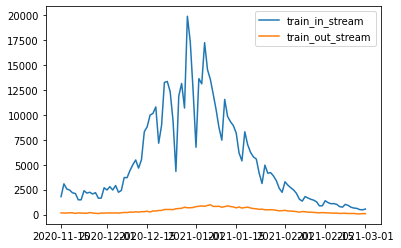

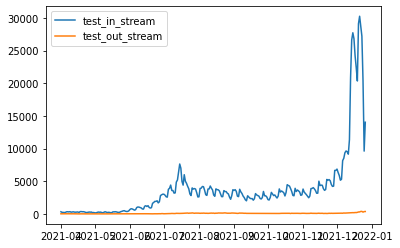

In [20]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [21]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [22]:
n_dim = 40
n_particles = 1000

x_max = 0.03*np.ones(n_dim)
x_min = -0.005*np.ones(n_dim)
options = {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2021-12-29 16:16:36,660 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=25.2
2021-12-29 16:16:59,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 25.155617869361162, best pos: [ 1.04094820e-03  3.01451077e-03  1.90790932e-03  5.44004261e-03
  2.16853734e-03  3.48780203e-03  7.95150834e-03  4.43311760e-03
  4.69227948e-03  1.11025800e-02  1.33495766e-03  3.00254901e-03
 -9.40105895e-06  5.82217402e-03  6.78841190e-03 -1.96713929e-03
  1.51259307e-03  1.28626828e-03  9.16309349e-04  1.28303693e-03
 -9.40877979e-04  1.45109521e-03 -1.00469203e-03  2.28709833e-05
 -1.42332186e-03 -1.02794607e-03 -2.23515624e-03  1.00716476e-03
 -2.73232759e-04  1.70561979e-03 -1.41182775e-03  1.92488612e-03
  4.92832434e-04 -9.91656053e-05  4.19428555e-03 -3.30206267e-04
  7.40458626e-04 -1.21050613e-03 -8.19119162e-04  2.51615529e-03]
2021-12-29 16:16:59,534 -

2021-12-29 16:18:57,425 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=21.5
2021-12-29 16:19:08,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.486725108385684, best pos: [ 1.06341668e-03  9.55705961e-03  2.58648102e-03  6.49635950e-03
  3.78943083e-03  2.92513494e-03  1.15932837e-02  4.84448045e-03
  5.50890617e-05  2.26520235e-03  1.35639027e-03  1.94634826e-03
  1.88043704e-03 -2.97836730e-04  6.98749805e-03 -5.49352659e-04
  4.85252892e-03  3.37471553e-03  7.79403716e-04 -1.89845458e-03
  1.20309478e-03  2.04879731e-03 -1.02869993e-03 -3.10478977e-04
 -1.92243689e-03 -4.97386014e-04  2.00164936e-03  3.34135196e-03
 -1.42946641e-03  2.57035222e-03 -8.04560285e-04 -1.33812630e-03
  9.63970004e-04 -1.51398038e-03  2.08704699e-04  4.00972451e-04
  8.94845271e-04  3.19072753e-04  1.19349061e-04  1.94442140e-03]
2021-12-29 16:19:08,335 -

2021-12-29 16:20:43,016 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=24.4
2021-12-29 16:20:54,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24.426892464216422, best pos: [ 3.71853850e-03  6.84485602e-03  4.66858665e-03  2.06844617e-03
  3.32252549e-03  3.70879419e-03  3.86124325e-03  6.59409646e-03
  1.53116658e-03  6.21605824e-03  4.76424764e-03  2.90506775e-03
  2.26528048e-03  6.40482652e-03  4.12797737e-03  5.03458905e-04
  1.17431506e-03  3.58565345e-04  3.34501338e-04 -1.56704433e-03
  2.00380525e-03  1.61092634e-03 -2.17205515e-03 -1.75518430e-04
 -5.15874917e-05 -8.18181167e-04 -7.84700524e-04 -3.77477135e-04
 -4.26535675e-04  7.19070432e-04  2.26275187e-05  1.07467315e-03
  1.59781548e-03  4.32832769e-04  3.80715442e-03  1.64584514e-04
  8.28693858e-04 -8.03540190e-04 -2.14134555e-04  4.00307434e-04]
2021-12-29 16:20:54,658 -

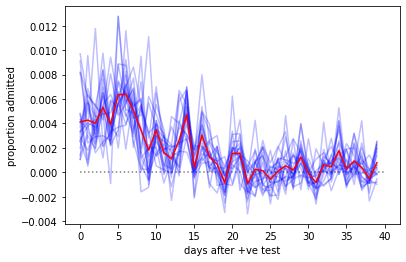

<Figure size 432x288 with 0 Axes>

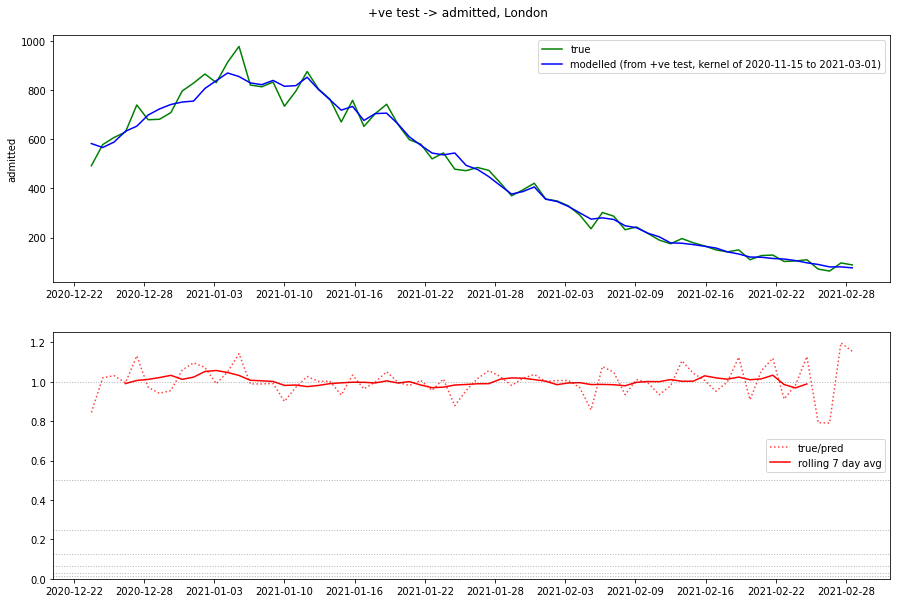

<Figure size 432x288 with 0 Axes>

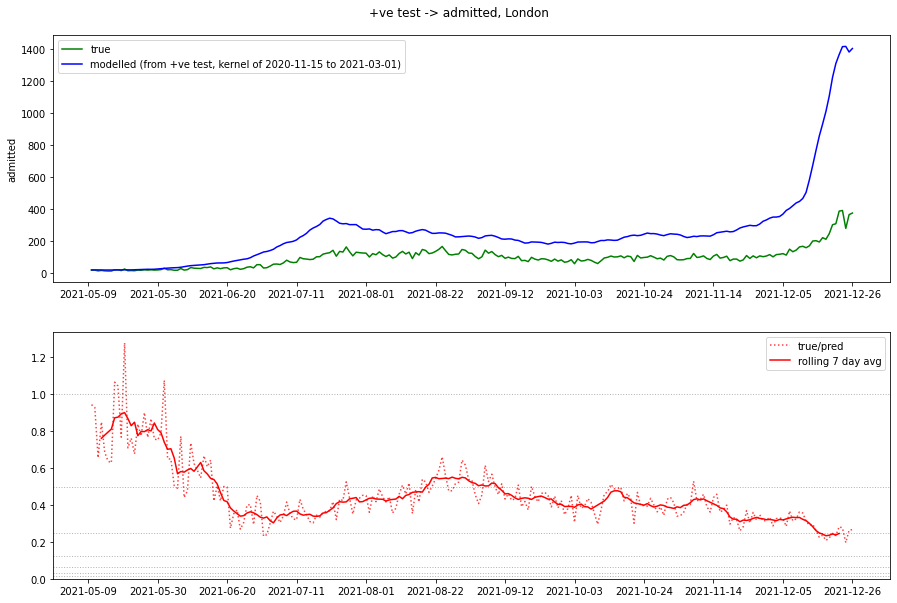

In [23]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, y, color="blue", alpha=0.25)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
plt.plot(z, avg_minimizer, color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.5, color="black")
plt.savefig("%s__%s__kernel__%s.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    true, pred = _f(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes
    ax1.plot(x, true, color="green", label="true")
    ax1.plot(x, pred, color="blue", label="modelled (from %s, kernel of %s to %s)" % (in_event, train_start_date, train_end_date))
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, true/pred, color="red", alpha=0.75, ls="dotted", label="true/pred")
    ax2.plot(x, N_avg_preserve(true/pred), color="red", label="rolling 7 day avg")
    #ax2.axhline(y=(true/pred)[-1], ls="dashed", lw=1, alpha=0.3, color="black")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    fig.suptitle("%s -> %s, %s" % (in_event, out_event, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 




In [12]:
print(avg_minimizer)

[-1.60792188e-05 -1.20617818e-03 -3.64924876e-04  8.94272959e-04
 -4.75741618e-04  1.71916947e-03  1.17400241e-03  1.57056673e-03
  2.56559527e-04  7.81250395e-04  4.93710575e-04  1.08186595e-04
  2.63262344e-04  9.32116083e-04  3.66200035e-03  7.59250547e-04
  6.53025708e-04  1.17515102e-03  4.50925064e-04  1.18385585e-03
  2.41493371e-03  1.81941466e-03 -3.10514124e-04  3.12102647e-04
  2.07469316e-04 -1.13134975e-03 -2.48581261e-04  3.55128694e-04
  4.43385276e-03  1.21260426e-04  8.04113307e-05 -5.32331682e-04
 -1.31110119e-03 -5.87458025e-04  2.76842846e-04  2.40008945e-03
  9.32476619e-04  2.20264374e-03  2.55536215e-03  1.83801472e-03]
